In [132]:
import geostatspy.GSLIB as GSLIB                          # Utilidades GSLIB y funciones envueltas
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import os                                                 # Para configurar el directorio de trabajo
import numpy as np                                        # Biblioteca de funciones matemáticas
import pandas as pd                                       # Biblioteca para manipulación de marcos de datos
import matplotlib.pyplot as plt                           # Biblioteca para salida gráfica
import scipy.stats                                        # Biblioteca de resumenes estadísticos y matemáticos
import random as rand
from sklearn.metrics import r2_score
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.optimizers import RMSprop 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import pygeostat as gs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import random
from RBFN import *
plt.rcParams.update(plt.rcParamsDefault)

os.chdir("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER") # ruta de ejecutables de GSLIB

In [247]:
nx = 100; ny = 50; cell_size=10                             # grid number of cells and cell size
xmin = 0; ymin =0;                                          # grid origin
xmax = 1000; ymax = 500    # calculate the extent of model
seed = 172763650
vmin = 0; vmax = 1; cmap = plt.cm.jet                     # color min and max and using the plasma color map
va_mean = 2; va_stdev = 0.55; va_cmin = 0; va_cmax = 4
var = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=250,hmin1=250)
V = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed,var,"u")
V = GSLIB.affine(V,va_mean,va_stdev)
df_zko = pd.DataFrame(V)
df11 = df_zko.stack().reset_index().rename(columns={"level_0": "Elevation[Z]", "level_1": "Este[X]", 0:"V"})
x = df11["Elevation[Z]"].iloc[::-1].reset_index()
df11["Elevation[Z]"] = x["Elevation[Z]"]
##############################################################################################################
grid_x = np.linspace(0,500, num=50, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.
gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 
yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)
x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg
d = {'X': x_g, 'Y': y_g} #Columnas con coordenadas X e Y.
df = pd.DataFrame(data=d) #Creación del dataframe 
h = df["Y"].iloc[::-1].reset_index()
df["Y"] = h["Y"]
df["V"] = df11["V"] #Traspaso de la columna VA al nuevo DataFrame.
df.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/data_test_2.csv")
#valores_x = [50, 350,650,8950]
valores_x = [50,250,350,450,550,650,750,950]
df_filtrado = df[df['X'].isin(valores_x)].copy()

for x in [950]:
    df_filtrado = df_filtrado.loc[~((df_filtrado['X'] == x) & ((df_filtrado['Y'] <= 300)))]
    
for x in [50]:
    df_filtrado = df_filtrado.loc[~((df_filtrado['X'] == x) & ((df_filtrado['Y'] <= 300)))]

df_filtrado.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/sample_dh_test2.csv")

In [248]:
df.head()

,X,Y,V
0,0.0,490.0,1.425655
1,10.0,490.0,1.398962
2,20.0,490.0,1.188708
3,30.0,490.0,0.992036
4,40.0,490.0,0.680945


In [249]:
numero_muestra = 200  # Número de valores en la muestra aleatoria

indices_aleatorios = random.sample(range(len(df)), numero_muestra)

df_muestra = df.loc[indices_aleatorios].reset_index(drop=True)

# Concatena df_muestra y df_filtrado
df_concatenado = pd.concat([df_muestra, df_filtrado], ignore_index=True)

# Ahora, df_concatenado contiene la unión de los DataFrames df_muestra y df_filtrado
df_concatenado.head()

,X,Y,V
0,360.0,490.0,1.623388
1,760.0,20.0,1.338566
2,710.0,200.0,1.378109
3,960.0,10.0,3.393614
4,690.0,260.0,2.276936


Coeficiente de correlación lineal: 0.65


<Figure size 820x420 with 0 Axes>

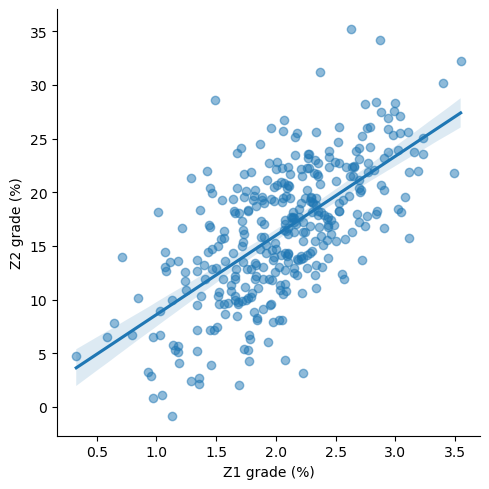

In [250]:

intensidad_ruido = 4.9  # Puedes ajustar este valor según tus necesidades

df_concatenado['V'] = df_concatenado['V']*8 + np.random.normal(0, intensidad_ruido, len(df_concatenado))

import seaborn as sns

coincidencias = df_filtrado.merge(df_concatenado, on=['X', 'Y'], suffixes=('_filtrado', '_concatenado'), how='inner')
plt.figure(figsize=(8.2, 4.2))
# Crear un gráfico de dispersión con línea de regresión para comparar "V_filtrado" y "V_concatenado"
sns.lmplot(x='V_filtrado', y='V_concatenado', data=coincidencias, scatter_kws={'alpha': 0.5})

# Agregar etiquetas
plt.xlabel('Z1 grade (%)')
plt.ylabel('Z2 grade (%)')

# Calcular el coeficiente de correlación lineal
coeficiente_correlacion = coincidencias['V_filtrado'].corr(coincidencias['V_concatenado'])
print(f'Coeficiente de correlación lineal: {coeficiente_correlacion:.2f}')

plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/regresion.png", dpi=300)
plt.show()


In [157]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
marker_size=15
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size, df_filtrado["V"], cmap = cmap, marker="s")
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.grid(False)
plt.title("I.A")
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/muestra_estandar_v.png", dpi=300)
plt.plot()

[]

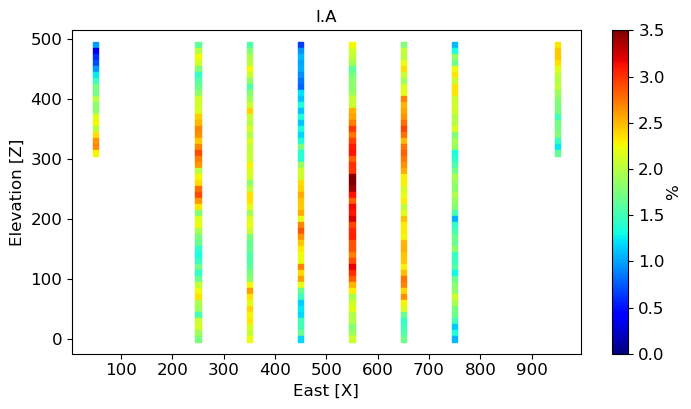

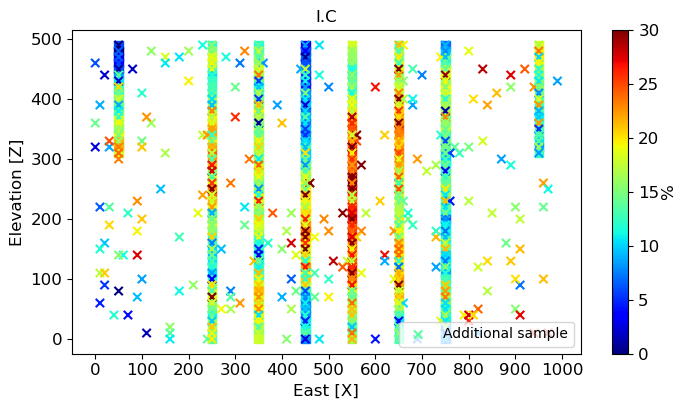

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que df_filtrado y df_concatenado ya están definidos

marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df_filtrado['X'], df_filtrado['Y'], c=df_filtrado['V'], cmap='jet', marker="s")

# Crear un diagrama de dispersión para df_concatenado
plt.scatter(df_concatenado['X'], df_concatenado['Y'], c=df_concatenado['V'], cmap='jet', marker='x', label='Additional sample')

plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.title("I.C")
plt.legend()
cbar = plt.colorbar()
plt.clim(0, 30)

cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/muestreo_hererotopico_parcial.png", dpi=300)

plt.show()


In [159]:
df_concatenado = df_concatenado.drop_duplicates(subset=['X', 'Y'], keep='first')
df_concatenado.describe().T

,count,mean,std,min,25%,50%,75%,max
X,523.0,489.847036,253.224371,0.000000,290.000000,480.000000,660.000000,990.000000
Y,523.0,250.535373,147.075254,0.000000,120.000000,250.000000,380.000000,490.000000
V,523.0,16.394565,6.903310,-1.680636,11.538026,16.223994,20.957406,39.813082


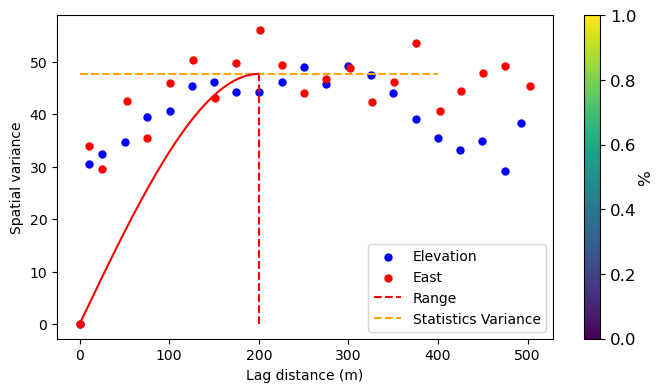

In [160]:
lag000, vario000, npp000 = GSLIB.gamv_2d(df_concatenado,'X','Y','V',20,25,0,12.5,25)
lag090, vario090, npp090 = GSLIB.gamv_2d(df_concatenado,'X','Y','V',20,25,90,12.5,25)

fig = plt.figure(figsize=(8,4.2))
plt.scatter(lag000,vario000,s=25,marker='o',color = 'blue',label = 'Elevation')
plt.scatter(lag090,vario090,s=25,marker='o',color = 'red',label = 'East')

alcance = 200
meseta1 = df_concatenado["V"].var()

plt.plot([alcance,alcance],[0,meseta1],color = 'red', label="Range", linestyle='dashed')

plt.plot([0,alcance*2],[meseta1,meseta1],color = 'orange',label = 'Statistics Variance', linestyle='dashed')



x = np.arange(0,alcance,1)
y = ((1.5*(x/alcance)) - (0.5*(x/alcance)**3))*meseta1
plt.plot(x,y, color = 'red')
plt.xlabel('Lag distance (m)')
plt.ylabel('Spatial variance')
#plt.ylim(0,0.5)
#plt.xlim(0,400)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::], labels[::])
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/variograma_modelo.png", dpi=300)

plt.show()

In [161]:
vario_kri1 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=meseta1,azi1=0,hmaj1=200,hmin1=200) #ajuste con un unico modelo esférico 

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


In [162]:
nx = 100; ny=50; xsiz=10; ysiz=10; xmn=0; ymn= 0; ndmax=20; ndmin=4;radius=200; 

ktype=1; skmean=0; nxdis=1; nydis=1; tmin=-9999; tmax=9999

kmap1, vmap1 = geostats.kb2d(df_concatenado, "X", "Y", "V", tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, nxdis, nydis, ndmin, ndmax, radius, ktype, skmean, vario_kri1)

  Estimated   5000 blocks 
      average   16.216245439608965  variance  28.478787169350994


In [163]:
xmin = 0; ymin =0;                                          # grid origin

xmax = 1000; ymax = 500    # calculate the extent of model

In [164]:
df_kmap1 = pd.DataFrame(kmap1) #se pasan los valores estimados al dataframe de la simulación 
df_vmap1 = pd.DataFrame(vmap1) #se pasan los valores estimados al dataframe de la simulación 

df_vmap1 = df_vmap1.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Var"})
df_kmap1 = df_kmap1.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Ore grade"})

df["Var"] = df_vmap1["Var"]
df["V1_OK"]= df_kmap1["Ore grade"]
df.head()

,X,Y,V,Var,V1_OK
0,0.0,490.0,1.425655,16.589642,4.521475
1,10.0,490.0,1.398962,14.776734,3.890488
2,20.0,490.0,1.188708,12.896495,3.284263
3,30.0,490.0,0.992036,10.063015,2.698229
4,40.0,490.0,0.680945,5.821442,1.893755


In [165]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
marker_size=15
plt.scatter(df["X"], df["Y"], marker_size, df["V1_OK"], cmap = cmap, marker="s")
#plt.title("Hybrid Model (Kriging and Neural Network)")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
#plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/sample_regular_mlp_100.png", dpi=300)
plt.plot()

[]

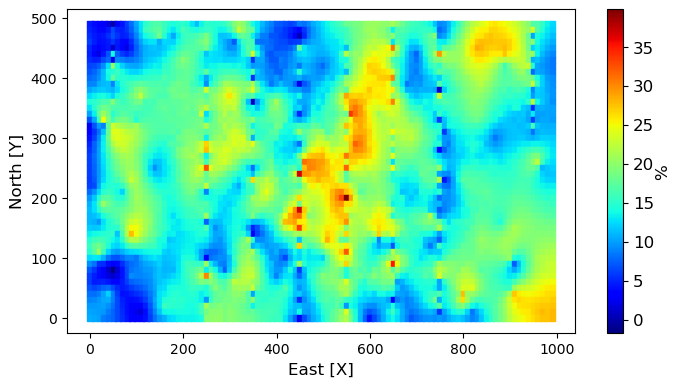

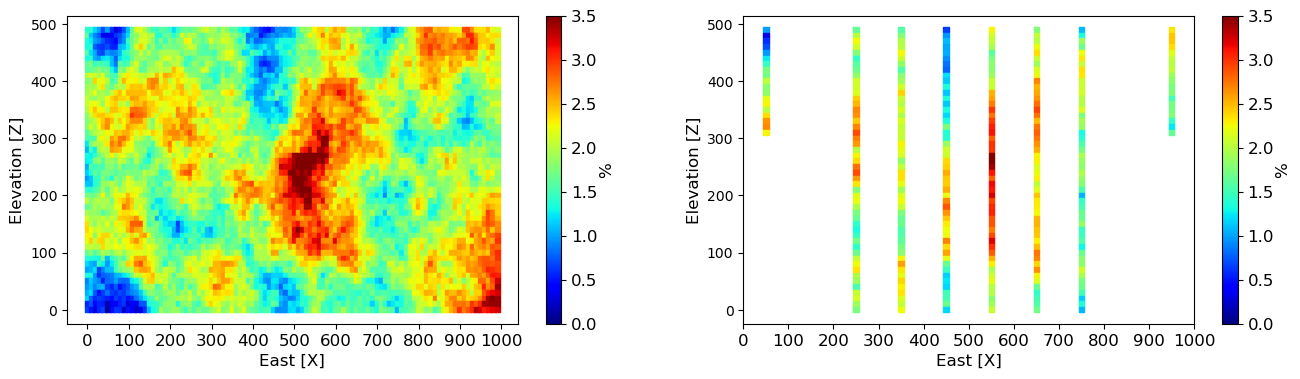

In [166]:
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["V"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size,df_filtrado["V"], cmap = cmap, marker="s")
#plt.title("Drillholes spacing 150 m", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Figuras paper 1/figure_2.png", dpi=300)
plt.show()

In [167]:
valores_x = [50,250,350,450,550,650,750,950]
df_filtradox = df[df['X'].isin(valores_x)].copy()

for x in [950]:
    df_filtradox = df_filtradox.loc[~((df_filtradox['X'] == x) & ((df_filtradox['Y'] <= 300)))]
    
for x in [50]:
    df_filtradox = df_filtradox.loc[~((df_filtradox['X'] == x) & ((df_filtradox['Y'] <= 300)))]

df_filtradox.describe().T

,count,mean,std,min,25%,50%,75%,max
X,338.0,5.000000e+02,2.209032e+02,5.000000e+01,3.500000e+02,5.000000e+02,6.500000e+02,9.500000e+02
Y,338.0,2.624260e+02,1.458812e+02,0.000000e+00,1.400000e+02,2.800000e+02,3.900000e+02,4.900000e+02
V,338.0,2.043045e+00,5.446064e-01,3.286406e-01,1.697173e+00,2.069206e+00,2.367995e+00,3.546454e+00
Var,338.0,5.125039e-15,1.732903e-13,-5.002586e-13,-1.200758e-13,1.409981e-14,1.344813e-13,5.020022e-13
V1_OK,338.0,1.653965e+01,6.956165e+00,-2.282715e-01,1.195005e+01,1.624851e+01,2.084224e+01,3.981308e+01


In [168]:
df["GEO"] = df["V1_OK"]

df_filtrado['GEO'] = df_filtradox["V1_OK"]


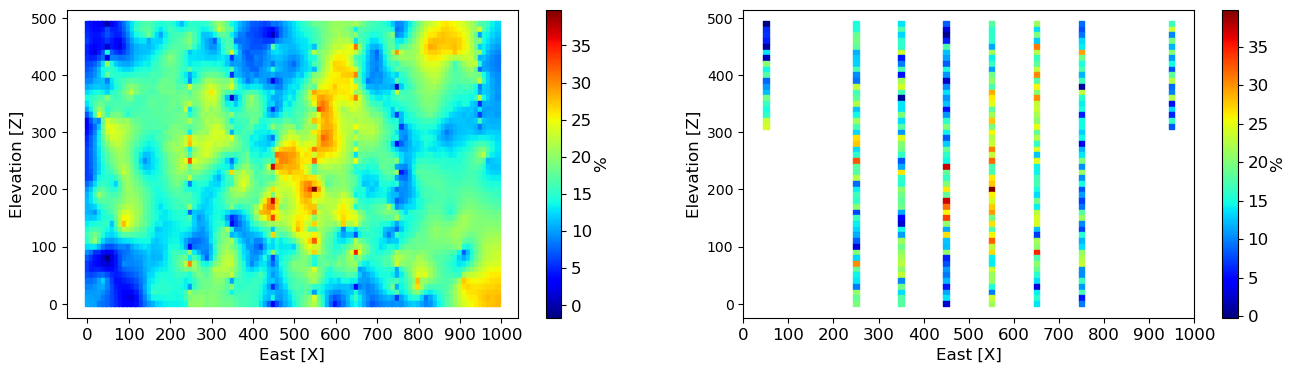

In [169]:
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["GEO"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
#plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size,df_filtrado["GEO"], cmap = cmap, marker="s")
#plt.title("Drillholes spacing 150 m", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
#plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Figuras paper 1/figure_2.png", dpi=300)
plt.show()

In [170]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df_filtrado["X"], df_filtrado["Y"], marker_size,df_filtrado["GEO"], cmap = cmap, marker="s")
#plt.title("Drillholes spacing 150 m", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 27)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/segunda_variable.png", dpi=300)
plt.plot()

[]

**B.	Muestreo irregular donde se conoce la ley mineral y un control geológico**

In [171]:
df_filtrado.describe().T

,count,mean,std,min,25%,50%,75%,max
X,338.0,500.000000,220.903191,50.000000,350.000000,500.000000,650.000000,950.000000
Y,338.0,262.426036,145.881244,0.000000,140.000000,280.000000,390.000000,490.000000
V,338.0,2.043045,0.544606,0.328641,1.697173,2.069206,2.367995,3.546454
GEO,338.0,16.539652,6.956165,-0.228271,11.950051,16.248506,20.842244,39.813082


# Modelo MLP:

In [172]:
X = df_filtrado.drop(["V"],axis=1) 
y = df_filtrado["V"]
X.head()

,X,Y,GEO
5,50.0,490.0,-0.228271
25,250.0,490.0,15.140974
35,350.0,490.0,13.801844
45,450.0,490.0,8.507381
55,550.0,490.0,18.164332


In [173]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state=17276)

In [174]:
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
X_train.rename(columns={0:"X", 1:"Y", 2: "GEO"}, inplace=True)
X_test.rename(columns={0:"X", 1:"Y", 2: "GEO"}, inplace=True)

In [175]:
network = models.Sequential()
network.add(layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(1)) 
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                256       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12801 (50.00 KB)
Trainable params: 12801 (50.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [176]:
network.compile(
   loss = 'mean_squared_error', 
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)

In [177]:
history = network.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/1000
10/10 [==============================] - 1s 20ms/step - loss: 1.4801 - val_loss: 0.4860
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.4014 - val_loss: 0.3715
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.2228 - val_loss: 0.2677
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.1857 - val_loss: 0.2031
Epoch 5/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.1427 - val_loss: 0.1862
Epoch 6/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.1322 - val_loss: 0.1787
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.1291 - val_loss: 0.1597
Epoch 8/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.1196 - val_loss: 0.1631
Epoch 9/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.1110 - val_loss: 0.1699
Epoch 10/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.1100 - val_loss: 0.139

10/10 [==============================] - 0s 4ms/step - loss: 0.0330 - val_loss: 0.1132
Epoch 83/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0307 - val_loss: 0.1374
Epoch 84/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0346 - val_loss: 0.1291
Epoch 85/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0361 - val_loss: 0.1546
Epoch 86/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0356 - val_loss: 0.1285
Epoch 87/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0288 - val_loss: 0.1239
Epoch 88/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0286 - val_loss: 0.1548
Epoch 89/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0331 - val_loss: 0.1240
Epoch 90/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0350 - val_loss: 0.1212
Epoch 91/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.1547
Epoc

10/10 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.1289
Epoch 163/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.1276
Epoch 164/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0174 - val_loss: 0.1435
Epoch 165/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0246 - val_loss: 0.1528
Epoch 166/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0288 - val_loss: 0.1154
Epoch 167/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0205 - val_loss: 0.1351
Epoch 168/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 0.1598
Epoch 169/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0240 - val_loss: 0.1521
Epoch 170/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0203 - val_loss: 0.1095
Epoch 171/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0267 - val_loss: 0.

10/10 [==============================] - 0s 8ms/step - loss: 0.0180 - val_loss: 0.1626
Epoch 243/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0150 - val_loss: 0.1365
Epoch 244/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.1295
Epoch 245/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.1375
Epoch 246/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.1111
Epoch 247/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.1369
Epoch 248/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.1187
Epoch 249/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.1444
Epoch 250/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.1306
Epoch 251/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.1377
Epoch 323/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.1186
Epoch 324/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.1271
Epoch 325/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.1348
Epoch 326/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.1333
Epoch 327/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.1232
Epoch 328/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.1185
Epoch 329/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0186 - val_loss: 0.1164
Epoch 330/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0128 - val_loss: 0.1418
Epoch 331/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.1289
Epoch 403/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.1285
Epoch 404/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.1265
Epoch 405/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.1268
Epoch 406/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.1212
Epoch 407/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0083 - val_loss: 0.1273
Epoch 408/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.1115
Epoch 409/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.1221
Epoch 410/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.1344
Epoch 411/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.1194
Epoch 483/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.1555
Epoch 484/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.1025
Epoch 485/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.1513
Epoch 486/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.1605
Epoch 487/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.1267
Epoch 488/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.1447
Epoch 489/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.1371
Epoch 490/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.1301
Epoch 491/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.1704
Epoch 563/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0092 - val_loss: 0.1316
Epoch 564/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.1544
Epoch 565/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.1295
Epoch 566/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.1605
Epoch 567/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.1277
Epoch 568/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.1409
Epoch 569/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.1341
Epoch 570/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0105 - val_loss: 0.1618
Epoch 571/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0099 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.1186
Epoch 643/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.1275
Epoch 644/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.1373
Epoch 645/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.1327
Epoch 646/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.1500
Epoch 647/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.1557
Epoch 648/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0091 - val_loss: 0.1181
Epoch 649/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0115 - val_loss: 0.1478
Epoch 650/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0093 - val_loss: 0.1474
Epoch 651/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.

10/10 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.1248
Epoch 723/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.1311
Epoch 724/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.1355
Epoch 725/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.1132
Epoch 726/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.1438
Epoch 727/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.1266
Epoch 728/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.1382
Epoch 729/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.1383
Epoch 730/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.1526
Epoch 731/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.1267
Epoch 803/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.1444
Epoch 804/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.1234
Epoch 805/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.1435
Epoch 806/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.1256
Epoch 807/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.1463
Epoch 808/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.1331
Epoch 809/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.1334
Epoch 810/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.1181
Epoch 811/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.

10/10 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.1376
Epoch 883/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.1350
Epoch 884/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.1393
Epoch 885/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.1323
Epoch 886/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.1507
Epoch 887/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.1435
Epoch 888/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.1278
Epoch 889/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.1329
Epoch 890/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.1298
Epoch 891/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.

10/10 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.1405
Epoch 963/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.1046
Epoch 964/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.1370
Epoch 965/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.1157
Epoch 966/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.1224
Epoch 967/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.1182
Epoch 968/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.1120
Epoch 969/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.1339
Epoch 970/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.1461
Epoch 971/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.

In [178]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = network.predict(X_train)
y_test_pred = network.predict(X_test)

# Métricas en el conjunto de entrenamiento
r_train = np.corrcoef(y_train, y_train_pred.squeeze())[0, 1]
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Métricas en el conjunto de prueba
r_test = np.corrcoef(y_test, y_test_pred.squeeze())[0, 1]
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Imprimir las métricas
print("Métricas en el conjunto de entrenamiento:")
print("R:", r_train)
print("R2:", r2_train)
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAE:", mae_train)
print("")

print("Métricas en el conjunto de prueba:")
print("R:", r_test)
print("R2:", r2_test)
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAE:", mae_test)

2/2 [==============================] - 0s 5ms/step
Métricas en el conjunto de entrenamiento:
R: 0.9960580111080051
R2: 0.9920864732827755
MSE: 0.002203790002218135
RMSE: 0.04694454177237366
MAE: 0.033819824455326

Métricas en el conjunto de prueba:
R: 0.8625936932592675
R2: 0.7385395135612527
MSE: 0.1165789253276641
RMSE: 0.34143656120524657
MAE: 0.2841390446459519


In [179]:
grid_x = np.linspace(0,500, num=50, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.

#En este caso la matriz es de 100 x 100 celdas.

gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 

yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)

x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg

d = {'Este[X]': x_g, 'Norte[Y]': y_g} #Columnas con coordenadas X e Y.
df2 = pd.DataFrame(data=d) #Creación del dataframe 

h = df2["Norte[Y]"].iloc[::-1].reset_index()

df2["Norte[Y]"] = h["Norte[Y]"]


#df5 = df_filtrado.reset_index()

df2["GEO"] = df["GEO"]

df2 = pd.DataFrame(StandardScaler().fit_transform(df2))
df2.rename(columns={0:"X", 1:"Y",2:"GEO"}, inplace=True)

df2.head()

,X,Y,GEO
0,-1.714816,1.697749,-2.191447
1,-1.680173,1.697749,-2.309686
2,-1.645531,1.697749,-2.423284
3,-1.610888,1.697749,-2.533099
4,-1.576245,1.697749,-2.683847


In [180]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,8.526513e-18,1.0001,-1.714816,-0.857408,0.0000,0.857408,1.714816
Y,5000.0,-9.094947e-17,1.0001,-1.697749,-0.866199,0.0000,0.866199,1.697749
GEO,5000.0,-2.728484e-16,1.0001,-3.353641,-0.641979,-0.0177,0.614939,4.421738


In [181]:
y_pred3 = network.predict(df2) #uso del modelo para un conjunto nuevo de datos de entrada (bloques zona óxido)
df2["VA_RNA"] = y_pred3
df["VA_RNA"] = df2["VA_RNA"]
df.head()

157/157 [==============================] - 0s 2ms/step


,X,Y,V,Var,V1_OK,GEO,VA_RNA
0,0.0,490.0,1.425655,16.589642,4.521475,4.521475,1.021089
1,10.0,490.0,1.398962,14.776734,3.890488,3.890488,1.029189
2,20.0,490.0,1.188708,12.896495,3.284263,3.284263,1.032904
3,30.0,490.0,0.992036,10.063015,2.698229,2.698229,1.032422
4,40.0,490.0,0.680945,5.821442,1.893755,1.893755,1.043206


In [182]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,495.000000,288.689571,0.000000e+00,247.500000,495.000000,742.500000,990.000000
Y,5000.0,245.000000,144.323130,0.000000e+00,120.000000,245.000000,370.000000,490.000000
V,5000.0,2.000000,0.550055,9.669300e-02,1.642968,2.000339,2.364052,3.931615
Var,5000.0,8.051445,4.435493,-5.002586e-13,5.156974,7.937687,10.878838,30.603764
V1_OK,5000.0,16.216245,5.337086,-1.680636e+00,12.790293,16.121789,19.497900,39.813082
GEO,5000.0,16.216245,5.337086,-1.680636e+00,12.790293,16.121789,19.497900,39.813082
VA_RNA,5000.0,1.983547,0.523400,5.420329e-01,1.623692,1.941319,2.324603,3.642370


In [183]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Supongamos que tienes dos arrays con valores reales (y_true) y predicciones (y_pred)
y_true = df["V"] 
y_pred = df["VA_RNA"] 

# Calcular las métricas
r = np.corrcoef(y_true, y_pred)[0, 1]
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# Imprimir los resultados
print(f"Coeficiente de correlación (R): {r:.4f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

Coeficiente de correlación (R): 0.5747
Coeficiente de determinación (R²): 0.1873
RMSE: 0.4958
MSE: 0.2458
MAE: 0.3922


In [184]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
marker_size=15
plt.scatter(df["X"], df["Y"], marker_size, df2["VA_RNA"], cmap = cmap, marker="s")
#plt.title("Hybrid Model (Kriging and Neural Network)")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/sample_regular_mlp_100.png", dpi=300)
plt.plot()

[]

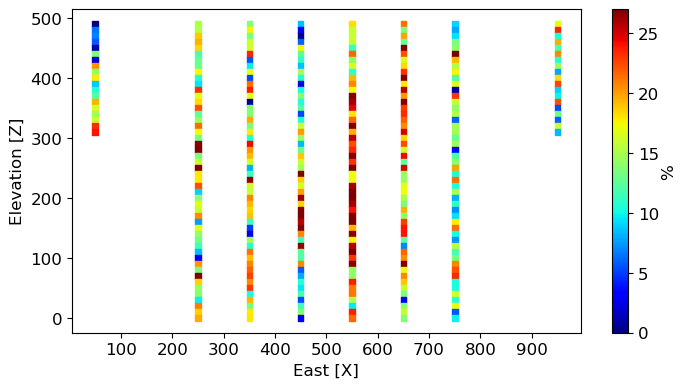

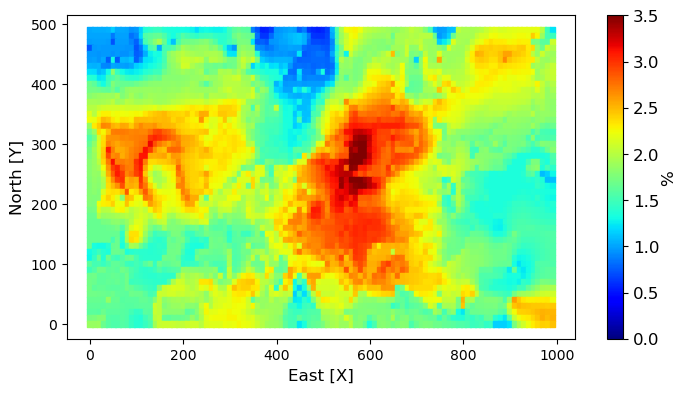

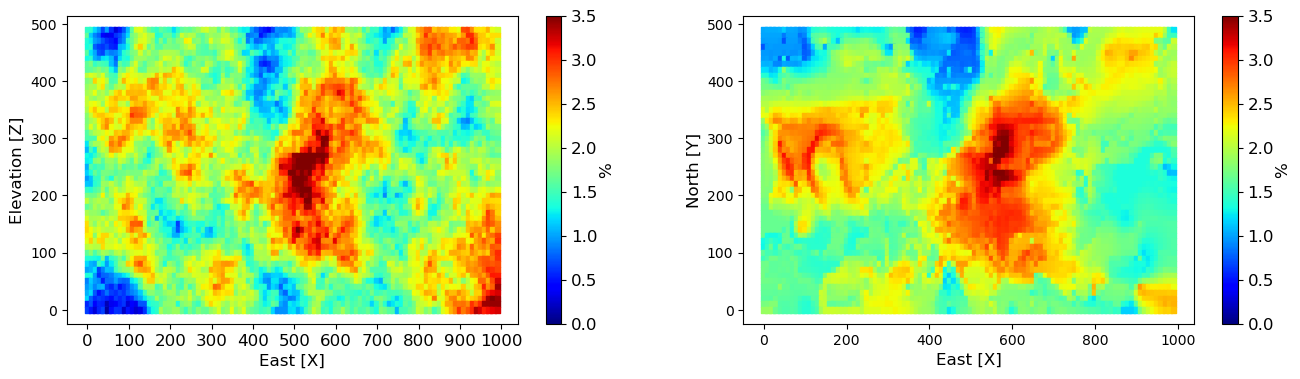

In [185]:
marker_size=16
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["V"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df["X"], df["Y"], marker_size, df2["VA_RNA"], cmap = cmap, marker="s")
#plt.title("Hybrid Model (Kriging and Neural Network)")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Figuras paper 1/figure_2.png", dpi=300)
plt.show()

# MODELO OK:

In [186]:
lag000, vario000, npp000 = GSLIB.gamv_2d(df_filtrado,'X','Y','V',20,25,0,12.5,25)
lag090, vario090, npp090 = GSLIB.gamv_2d(df_filtrado,'X','Y','V',20,25,90,12.5,25)


In [187]:
df_filtrado["V"].var()

0.2965961361135752

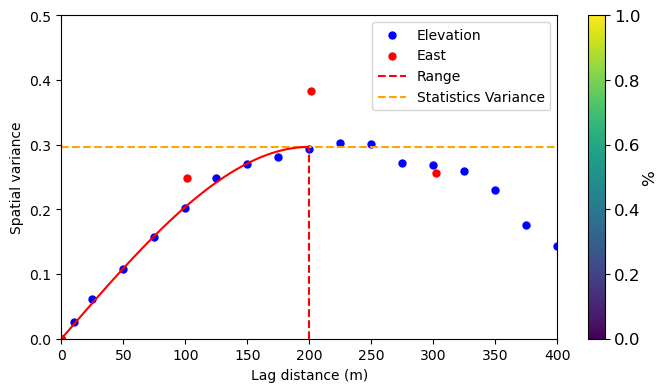

In [188]:
fig = plt.figure(figsize=(8,4.2))
plt.scatter(lag000,vario000,s=25,marker='o',color = 'blue',label = 'Elevation')
plt.scatter(lag090,vario090,s=25,marker='o',color = 'red',label = 'East')

alcance = 200
meseta = df_filtrado["V"].var()

plt.plot([alcance,alcance],[0,meseta],color = 'red', label="Range", linestyle='dashed')

plt.plot([0,alcance*2],[meseta,meseta],color = 'orange',label = 'Statistics Variance', linestyle='dashed')



x = np.arange(0,alcance,1)
y = ((1.5*(x/alcance)) - (0.5*(x/alcance)**3))*meseta
plt.plot(x,y, color = 'red')
plt.xlabel('Lag distance (m)')
plt.ylabel('Spatial variance')
plt.ylim(0,0.5)
plt.xlim(0,400)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::], labels[::])
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/variograma_modelo2.png", dpi=300)

plt.show()

In [189]:
vario_kri = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=meseta,azi1=0,hmaj1=200,hmin1=200) #ajuste con un unico modelo esférico 

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


In [190]:
nx = 100; ny=50; xsiz=10; ysiz=10; xmn=0; ymn= 0; ndmax=20; ndmin=1;radius=200; 

ktype=1; skmean=0; nxdis=1; nydis=1; tmin=-9999; tmax=9999

kmap, vmap = geostats.kb2d(df_filtrado, "X", "Y", "V", tmin, tmax, nx, xmn, xsiz, ny, ymn, ysiz, nxdis, nydis, ndmin, ndmax, radius, ktype, skmean, vario_kri)

  Estimated   5000 blocks 
      average   1.9716064651814784  variance  0.18067696724712734


In [191]:
xmin = 0; ymin =0;                                          # grid origin

xmax = 1000; ymax = 500    # calculate the extent of model

In [192]:
df_kmap = pd.DataFrame(kmap) #se pasan los valores estimados al dataframe de la simulación 
df_vmap = pd.DataFrame(vmap) #se pasan los valores estimados al dataframe de la simulación 

df_vmap = df_vmap.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Var"})
df_kmap = df_kmap.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Ore grade"})

df["Var"] = df_vmap["Var"]
df["V_OK"]= df_kmap["Ore grade"]
df.head()

,X,Y,V,Var,V1_OK,GEO,VA_RNA,V_OK
0,0.0,490.0,1.425655,0.187132,4.521475,4.521475,1.021089,1.062005
1,10.0,490.0,1.398962,0.152383,3.890488,3.890488,1.029189,0.996280
2,20.0,490.0,1.188708,0.116073,3.284263,3.284263,1.032904,0.929009
3,30.0,490.0,0.992036,0.078479,2.698229,2.698229,1.032422,0.867346
4,40.0,490.0,0.680945,0.039985,1.893755,1.893755,1.043206,0.839161


In [193]:
df["V_OK"].describe().T

count    5000.000000
mean        1.971606
std         0.425104
min         0.000000
25%         1.686157
50%         1.946080
75%         2.233815
max         3.546454
Name: V_OK, dtype: float64

In [194]:
df_vmap = df_vmap.stack().reset_index().rename(columns={"level_0": "North [Y]", "level_1": "East[X]", 0:"Var"})
df.head()

,X,Y,V,Var,V1_OK,GEO,VA_RNA,V_OK
0,0.0,490.0,1.425655,0.187132,4.521475,4.521475,1.021089,1.062005
1,10.0,490.0,1.398962,0.152383,3.890488,3.890488,1.029189,0.996280
2,20.0,490.0,1.188708,0.116073,3.284263,3.284263,1.032904,0.929009
3,30.0,490.0,0.992036,0.078479,2.698229,2.698229,1.032422,0.867346
4,40.0,490.0,0.680945,0.039985,1.893755,1.893755,1.043206,0.839161


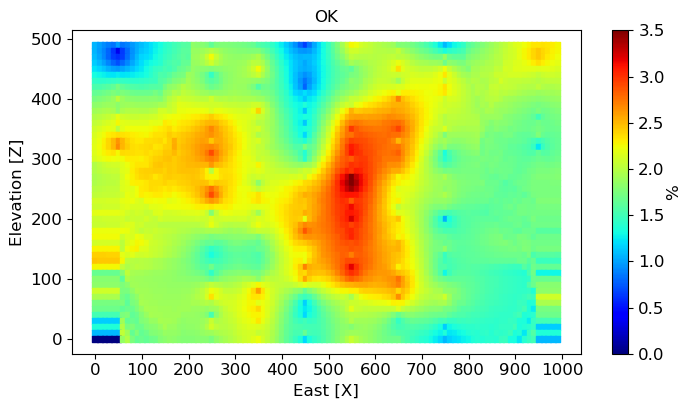

In [195]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df["X"], df["Y"], marker_size, df["V_OK"], cmap = cmap, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.title("OK")
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/OK_case1_result.png", dpi=300)

plt.show()

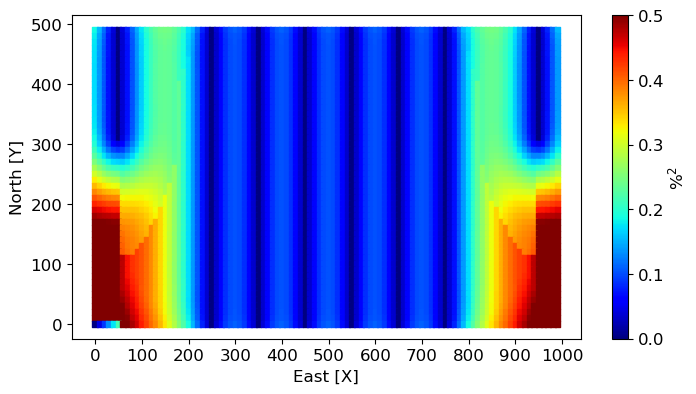

In [196]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df["X"], df["Y"], marker_size, df["Var"], cmap = cmap, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('North [Y]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 0.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("%$^2$", labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/var_escenario2_caso1.png", dpi=300)

plt.show()

In [197]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
x = df["V_OK"]
y = df["V"] 

# Suponiendo que x e y son arrays de NumPy o listas
# Si son series de pandas, puedes convertirlas usando: x = x.values, y = y.values

# Calcular el coeficiente de correlación lineal (R)
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y, x)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y, x)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = sqrt(mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y, x)

print(f"Coeficiente de correlación lineal (R): {correlation_coefficient}")
print(f"Coeficiente de determinación (R^2): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")

Coeficiente de correlación lineal (R): 0.6414807125432525
Coeficiente de determinación (R^2): 0.39157755581325726
Error cuadrático medio (MSE): 0.18404778936648972
Raíz del error cuadrático medio (RMSE): 0.42900791294157936
Error absoluto medio (MAE): 0.3106666661303056


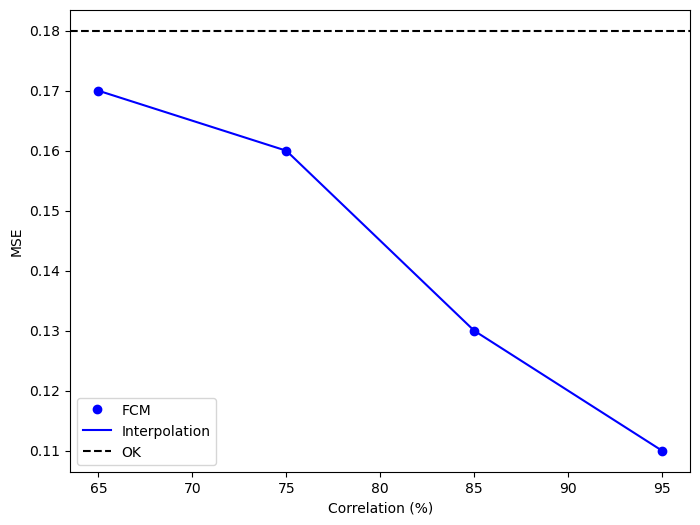

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Valores conocidos de R y sus correspondientes porcentajes
porcentajes_conocidos = np.array([65, 75, 85, 95])
valores_conocidos = np.array([0.17, 0.16, 0.13, 0.11])

# Generar valores de porcentaje desde 65% hasta 95% con un paso de 1%
porcentajes_interpolados = np.arange(65, 96, 1)

# Realizar la interpolación lineal
interp = interp1d(porcentajes_conocidos, valores_conocidos, kind='linear')
valores_interpolados = interp(porcentajes_interpolados)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(porcentajes_conocidos, valores_conocidos, 'o', label='FCM', color='blue')  # Cambiamos el color a azul
plt.plot(porcentajes_interpolados, valores_interpolados, '-', label='Interpolation', color='blue')  # Cambiamos el color a azul
plt.axhline(y=0.18, color='black', linestyle='--', label='OK')

plt.xlabel('Correlation (%)')
plt.ylabel('MSE')
plt.legend()

plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/correlacion_variable_aux.png", dpi=300)
plt.show()


# Modelo Hibrido MLP-OK

In [198]:
df.head()

,X,Y,V,Var,V1_OK,GEO,VA_RNA,V_OK
0,0.0,490.0,1.425655,0.187132,4.521475,4.521475,1.021089,1.062005
1,10.0,490.0,1.398962,0.152383,3.890488,3.890488,1.029189,0.996280
2,20.0,490.0,1.188708,0.116073,3.284263,3.284263,1.032904,0.929009
3,30.0,490.0,0.992036,0.078479,2.698229,2.698229,1.032422,0.867346
4,40.0,490.0,0.680945,0.039985,1.893755,1.893755,1.043206,0.839161


In [199]:
#Estandarización de la varianza:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df["Var_scaled"] = scaler.fit_transform(df[["Var"]])

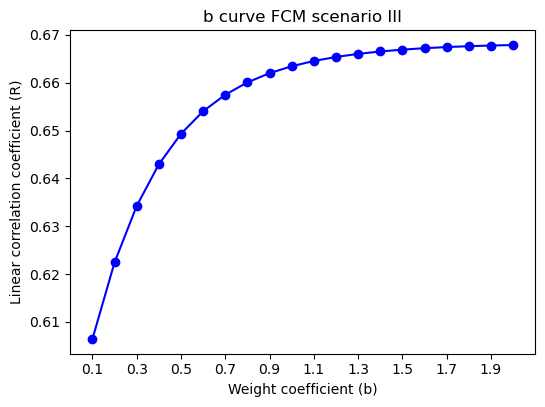

In [200]:
# Definir el rango de valores de b
b_values = np.arange(0.1, 2.1, 0.1)

# Inicializar listas para almacenar los valores de R para cada escenario de b
r_values = []

# Crear una figura para el gráfico
fig = plt.figure(figsize=(6, 4.2))

# Iterar a través de los valores de b y calcular los valores de R correspondientes
for b in b_values:
    df["b_05"] = df["Var_scaled"] ** b
    df["mlp_ok"] = ((df["VA_RNA"]*df["b_05"])+((1-df["b_05"])*df["V_OK"]))
    
    x = df["V"]
    y = df["mlp_ok"]
    r = np.corrcoef(x, y)[0, 1]
    
    r_values.append(r)

# Crear el gráfico de líneas para los valores de R
plt.plot(b_values, r_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Weight coefficient (b)")
plt.ylabel("Linear correlation coefficient (R)")
plt.title("b curve FCM scenario III")
plt.xticks(np.arange(0.1, 2.1, 0.2))  # Ajustar las marcas en el eje X para que se muestren cada unidad
plt.grid(False)
plt.xlim((0,2.1))
#plt.ylim((0.7, 0.76))
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/RFBNN_python/hibrid_figures/bcurve_e3.png", dpi=300)

plt.show()

In [201]:
df["b_05"] = df["Var_scaled"]**2 #se crea un nuevo peso (wi) que depende de var**0.5

In [202]:
df["mlp_ok"] = ((df["VA_RNA"]*df["b_05"])+((1-df["b_05"])*df["V_OK"])) #Estimación Hibrida con nuevo peso b=0.5

In [203]:
x = df["V"] 
y = df["mlp_ok"] 
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept
r2 = r2_score(y, regression_line)
r = np.corrcoef(x, y)[0, 1]

fig = plt.figure(figsize=(5,4))
plt.scatter(x, y, color='blue', s=5, label='Data Points')
#plt.title("Validation OK", fontsize=12)
plt.plot(x, regression_line, color='red', label='Regression Line')
plt.text(0.5,3.2, 'R = {:.2f}, R\u00b2 = {:.2f}'.format(r, r2))
plt.xlabel("Ore grade")
plt.ylabel("Ore grade estimated")
plt.xlim((-0.3,3.9))
plt.ylim((-0.3,3.9))
#plt.savefig("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER/data/dh_validation_ok_10percent.png", dpi=300)

(-0.3, 3.9)

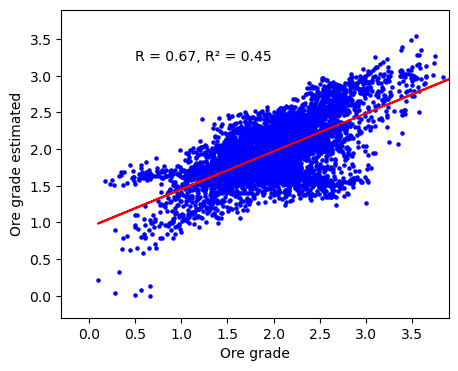

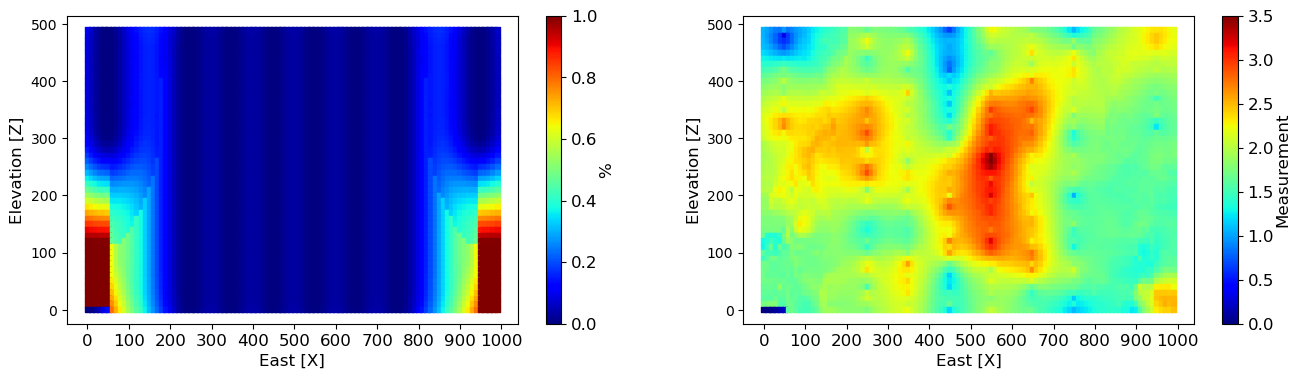

In [204]:
marker_size=15
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.scatter(df["X"], df["Y"], marker_size, df["b_05"], cmap = plt.cm.jet, marker="s")
#plt.title("SGSIM+Affine Correction", fontsize=20)
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 1)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
plt.subplot(122)
plt.scatter(df["X"], df["Y"], marker_size, df["mlp_ok"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Measurement', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/RFBNN_python/hibrid_figures/kriging.png", dpi=300)

plt.show()

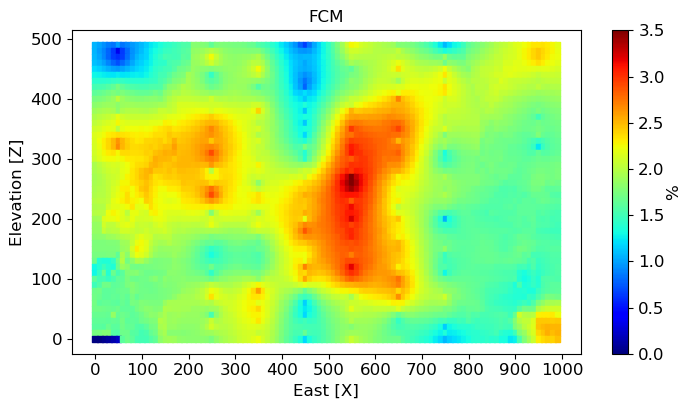

In [205]:
marker_size=16
plt.figure(figsize=(8.2, 4.2))
plt.scatter(df["X"], df["Y"], marker_size, df["mlp_ok"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.yticks(range(0, 501, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.title("FCM")
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('%', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/combinado_Flexible_caso1_esce3.png", dpi=300)

plt.show()

In [206]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
x = df["mlp_ok"]
y = df["V"] 

# Suponiendo que x e y son arrays de NumPy o listas
# Si son series de pandas, puedes convertirlas usando: x = x.values, y = y.values

# Calcular el coeficiente de correlación lineal (R)
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y, x)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y, x)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = sqrt(mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y, x)

print(f"Coeficiente de correlación lineal (R): {correlation_coefficient}")
print(f"Coeficiente de determinación (R^2): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")

Coeficiente de correlación lineal (R): 0.6678610878594056
Coeficiente de determinación (R^2): 0.43151970968843445
Error cuadrático medio (MSE): 0.17196528781924864
Raíz del error cuadrático medio (RMSE): 0.4146869757048666
Error absoluto medio (MAE): 0.3092620419934003


In [207]:
df.to_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/result_ok_mlp_case1_ESCENARIO_B.csv")

# MODELO RIGIDO:

In [69]:
df.head()

,X,Y,V,Var,V1_OK,GEO,VA_RNA,V_OK,Var_scaled,b_05,mlp_ok
0,0.0,490.0,1.425655,0.187132,8.497820,8.497820,1.092430,1.062005,0.315466,0.707434,1.083528
1,10.0,490.0,1.398962,0.152383,7.567427,7.567427,0.975693,0.996280,0.256886,0.665154,0.982587
2,20.0,490.0,1.188708,0.116073,6.920906,6.920906,0.930960,0.929009,0.195676,0.613001,0.930205
3,30.0,490.0,0.992036,0.078479,6.337004,6.337004,0.861693,0.867346,0.132300,0.545089,0.864264
4,40.0,490.0,0.680945,0.039985,6.025129,6.025129,0.796195,0.839161,0.067407,0.445257,0.820030


In [70]:
columnas = ["X","Y", "V", "VA_RNA", "Var", "V_OK"]
df_rigido = df[columnas]
df_rigido.head()

,X,Y,V,VA_RNA,Var,V_OK
0,0.0,490.0,1.425655,1.092430,0.187132,1.062005
1,10.0,490.0,1.398962,0.975693,0.152383,0.996280
2,20.0,490.0,1.188708,0.930960,0.116073,0.929009
3,30.0,490.0,0.992036,0.861693,0.078479,0.867346
4,40.0,490.0,0.680945,0.796195,0.039985,0.839161


In [71]:
# Crear la nueva columna 'rigid' con valores basados en la condición
df_rigido['rigid'] = df_rigido.apply(lambda row: row['VA_RNA'] if row['Var'] > 0.25 else row['V_OK'], axis=1)
df_rigido.head()

C:\TEMP\ipykernel_10228\3447138609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigido['rigid'] = df_rigido.apply(lambda row: row['VA_RNA'] if row['Var'] > 0.25 else row['V_OK'], axis=1)


,X,Y,V,VA_RNA,Var,V_OK,rigid
0,0.0,490.0,1.425655,1.092430,0.187132,1.062005,1.062005
1,10.0,490.0,1.398962,0.975693,0.152383,0.996280,0.996280
2,20.0,490.0,1.188708,0.930960,0.116073,0.929009,0.929009
3,30.0,490.0,0.992036,0.861693,0.078479,0.867346,0.867346
4,40.0,490.0,0.680945,0.796195,0.039985,0.839161,0.839161


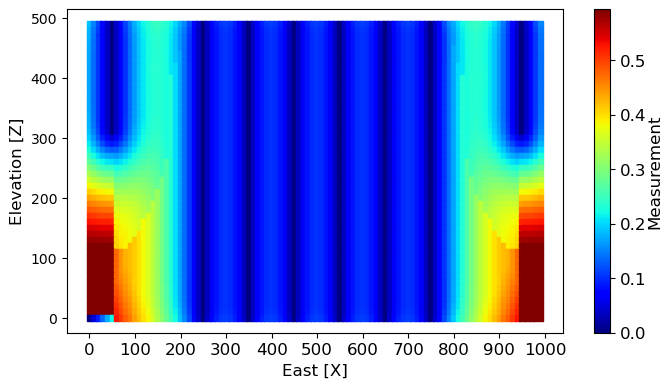

In [72]:
marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["Var"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
#plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Measurement', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/RFBNN_python/hibrid_figures/kriging.png", dpi=300)

plt.show()

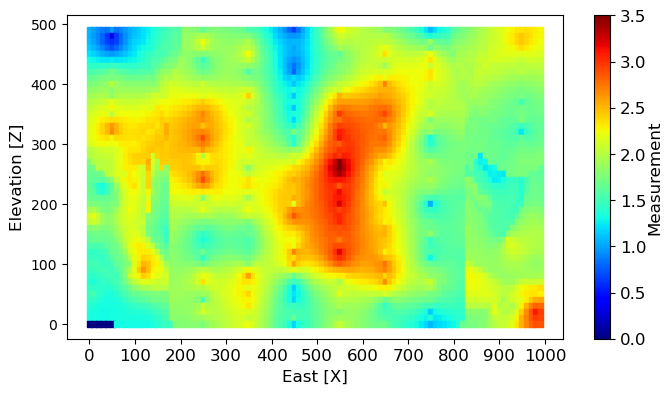

In [143]:
marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["rigid"], cmap=plt.cm.jet, marker="s")
#plt.title("Ore Grade Estimated OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 3.5)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Measurement', labelpad=+1, fontsize=12)
#plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/combinado_rigido.png", dpi=300)

plt.show()

In [74]:
x = df_rigido["rigid"]
y = df_rigido["V"]

# Suponiendo que x e y son arrays de NumPy o listas
# Si son series de pandas, puedes convertirlas usando: x = x.values, y = y.values

# Calcular el coeficiente de correlación lineal (R)
correlation_coefficient = np.corrcoef(x, y)[0, 1]

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y, x)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y, x)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = sqrt(mse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y, x)

print(f"Coeficiente de correlación lineal (R): {correlation_coefficient}")
print(f"Coeficiente de determinación (R^2): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")
print(f"Error absoluto medio (MAE): {mae}")

Coeficiente de correlación lineal (R): 0.7613214498101483
Coeficiente de determinación (R^2): 0.5779459713636598
Error cuadrático medio (MSE): 0.12767134366249294
Raíz del error cuadrático medio (RMSE): 0.35731126999087637
Error absoluto medio (MAE): 0.27423969307576873


In [75]:
df_rigido.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,495.000000,288.689571,0.000000e+00,247.500000,495.000000,742.500000,990.000000
Y,5000.0,245.000000,144.323130,0.000000e+00,120.000000,245.000000,370.000000,490.000000
V,5000.0,2.000000,0.550055,9.669300e-02,1.642968,2.000339,2.364052,3.931615
VA_RNA,5000.0,2.004151,0.463667,5.337577e-01,1.701616,2.012445,2.279066,3.710544
Var,5000.0,0.151371,0.139740,-3.103517e-15,0.062866,0.098316,0.224373,0.593192
V_OK,5000.0,1.971606,0.425104,0.000000e+00,1.686157,1.946080,2.233815,3.546454
rigid,5000.0,1.978766,0.426020,0.000000e+00,1.693816,1.954807,2.235988,3.546454


In [100]:
df_rigido["FCM"] = df["mlp_ok"]
df_rigido.describe().T

C:\TEMP\ipykernel_10228\1322662230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigido["FCM"] = df["mlp_ok"]


,count,mean,std,min,25%,50%,75%,max
X,5000.0,495.000000,288.689571,0.000000e+00,247.500000,495.000000,742.500000,990.000000
Y,5000.0,245.000000,144.323130,0.000000e+00,120.000000,245.000000,370.000000,490.000000
V,5000.0,2.000000,0.550055,9.669300e-02,1.642968,2.000339,2.364052,3.931615
VA_RNA,5000.0,2.004151,0.463667,5.337577e-01,1.701616,2.012445,2.279066,3.710544
Var,5000.0,0.151371,0.139740,-3.103517e-15,0.062866,0.098316,0.224373,0.593192
V_OK,5000.0,1.971606,0.425104,0.000000e+00,1.686157,1.946080,2.233815,3.546454
rigid,5000.0,1.978766,0.426020,0.000000e+00,1.693816,1.954807,2.235988,3.546454
FCM,5000.0,1.979936,0.419331,3.677186e-29,1.694877,1.946276,2.229791,3.546454


In [125]:
df45 = pd.read_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/df_rigido_rbf.csv")
df45.head()

,Unnamed: 0,X,Y,V,V_RBF,Var,V_OK,rigid,FCMe1
0,0,0.0,490.0,1.425655,1.153469,0.187132,1.062005,1.062005,1.071107
1,1,10.0,490.0,1.398962,1.085687,0.152383,0.996280,0.996280,1.002180
2,2,20.0,490.0,1.188708,1.026588,0.116073,0.929009,0.929009,0.932745
3,3,30.0,490.0,0.992036,0.980612,0.078479,0.867346,0.867346,0.869328
4,4,40.0,490.0,0.680945,0.951440,0.039985,0.839161,0.839161,0.839671


In [127]:
df_rigido["V_RBF"] = df45["V_RBF"]
df_rigido["FCMe1"] = df45["FCMe1"]
df_rigido["rCMe1"] = df45["rigid"]


In [130]:
df78 = pd.read_csv("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Hybrid_model_test_2023/df_rigido_e2.csv")
df78.head()

,Unnamed: 0,X,Y,V,VA_RNA,Var,V_OK,rigid,FCMe2,FCMe22
0,0,0.0,490.0,1.425655,1.439603,0.187132,1.062005,1.062005,1.057828,1.099583
1,1,10.0,490.0,1.398962,1.422443,0.152383,0.996280,0.996280,0.998826,1.024402
2,2,20.0,490.0,1.188708,1.405215,0.116073,0.929009,0.929009,0.933845,0.947243
3,3,30.0,490.0,0.992036,1.392186,0.078479,0.867346,0.867346,0.871895,0.876532
4,4,40.0,490.0,0.680945,1.381803,0.039985,0.839161,0.839161,0.840795,0.841626


In [131]:
df_rigido["NNE2"] = df78["VA_RNA"]
df_rigido["FCME2"] = df78["FCMe22"]
df_rigido["RCME2"] = df78["rigid"]

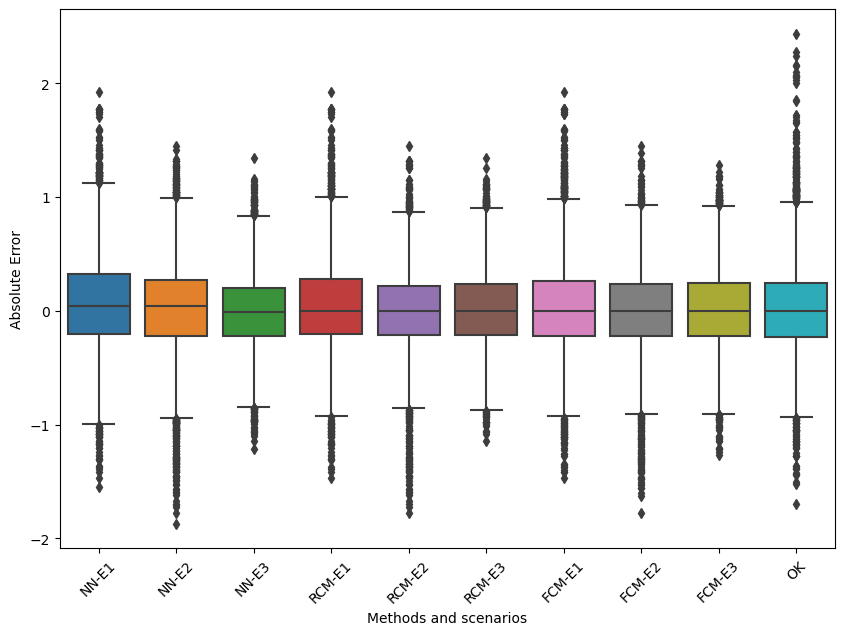

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Variables de interés
variables = ['V_RBF','NNE2','VA_RNA', 'rCMe1','RCME2','rigid','FCMe1','FCME2', 'FCM', 'V_OK']

# Cálculo de errores para cada variable
errores = {}
for variable in variables:
    errores[variable] = df_rigido['V'] - df_rigido[variable]

# Crear un gráfico de caja (boxplot) para comparar los errores
fig = plt.figure(figsize=(10,7))
sns.boxplot(data=pd.DataFrame(errores))
plt.xlabel('Methods and scenarios')
plt.ylabel('Absolute Error')

plt.xticks(rotation=45)
plt.gca().set_xticklabels(['NN-E1','NN-E2','NN-E3','RCM-E1','RCM-E2','RCM-E3','FCM-E1','FCM-E2','FCM-E3', 'OK'])  # Cambia los nombres en el eje x
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/resultados_scenario3.png", dpi=300)

plt.show()


In [138]:
df_rigido.head()

,X,Y,V,VA_RNA,Var,V_OK,rigid,FCM,V_RBF,NNE2,FCME2,RCME2,FCMe1,rCMe1
0,0.0,490.0,1.425655,1.092430,0.187132,1.062005,1.062005,1.065033,1.153469,1.439603,1.099583,1.062005,1.071107,1.062005
1,10.0,490.0,1.398962,0.975693,0.152383,0.996280,0.996280,0.994921,1.085687,1.422443,1.024402,0.996280,1.002180,0.996280
2,20.0,490.0,1.188708,0.930960,0.116073,0.929009,0.929009,0.929084,1.026588,1.405215,0.947243,0.929009,0.932745,0.929009
3,30.0,490.0,0.992036,0.861693,0.078479,0.867346,0.867346,0.867247,0.980612,1.392186,0.876532,0.867346,0.869328,0.867346
4,40.0,490.0,0.680945,0.796195,0.039985,0.839161,0.839161,0.838966,0.951440,1.381803,0.841626,0.839161,0.839671,0.839161


In [175]:
df_rigido["errorrcme3"] = (df_rigido["V"]-df_rigido["rigid"])**2

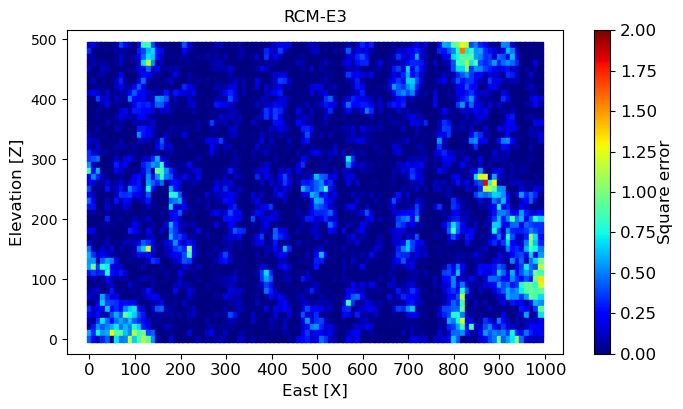

In [177]:
marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["errorrcme3"], cmap=plt.cm.jet, marker="s")
plt.title("RCM-E3")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Square error', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/errores_rcme3.png", dpi=300)

plt.show()

In [156]:
df_rigido["errorfcme3"] = (df_rigido["V"]-df_rigido["FCM"])**2

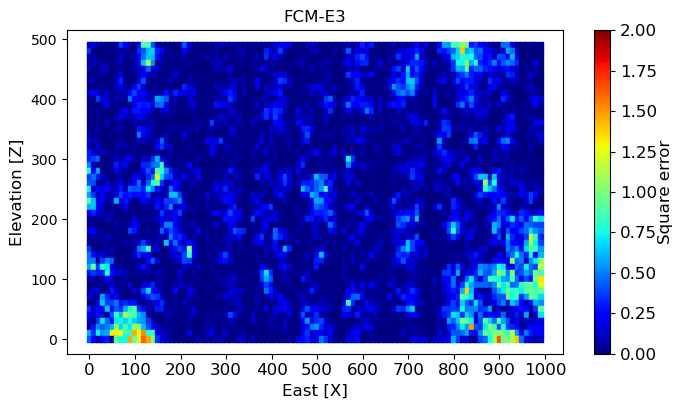

In [171]:
marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["errorfcme3"], cmap=plt.cm.jet, marker="s")
plt.title("FCM-E3")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Square error', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/errores_fcme3.png", dpi=300)

plt.show()

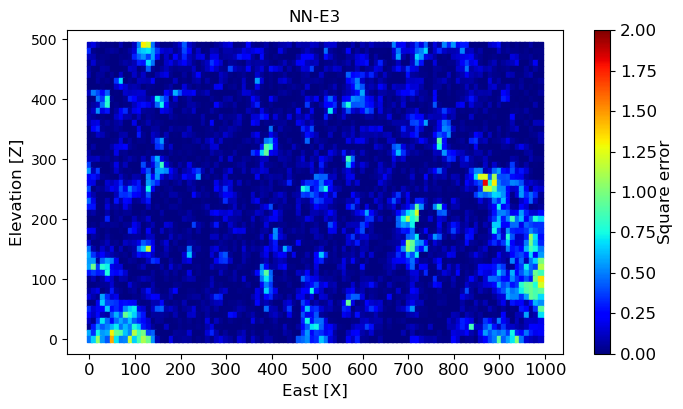

In [172]:
df_rigido["errorrna"] = (df_rigido["V"]-df_rigido["VA_RNA"])**2

marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["errorrna"], cmap=plt.cm.jet, marker="s")
plt.title("NN-E3")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Square error', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/errores_red.png", dpi=300)

plt.show()

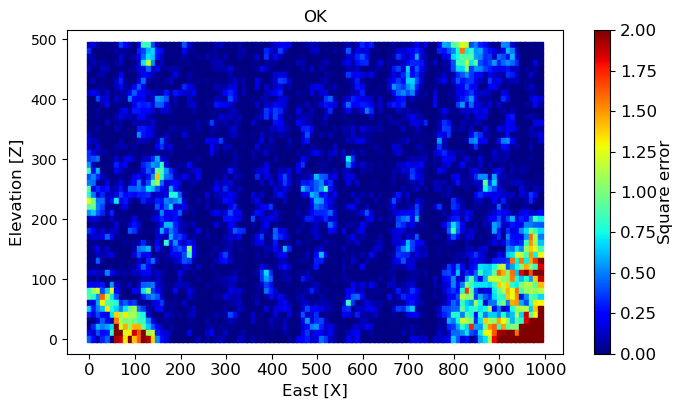

In [173]:
df_rigido["errorok"] = (df_rigido["V"]-df_rigido["V_OK"])**2

marker_size=15
fig = plt.figure(figsize=(8,4.2))

plt.scatter(df_rigido["X"], df_rigido["Y"], marker_size, df_rigido["errorok"], cmap=plt.cm.jet, marker="s")
plt.title("OK")
plt.xlabel('East [X]', fontsize=12)
plt.ylabel('Elevation [Z]', fontsize=12)
plt.xticks(range(0, 1001, 100), fontsize=12)
plt.grid(False)
cbar = plt.colorbar()
plt.clim(0, 2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Square error', labelpad=+1, fontsize=12)
plt.savefig("C:/Users/nubem/Desktop/TESIS DOCTORAL 2023-2024/Tesis_parte_3/Figuras/errores_ok.png", dpi=300)

plt.show()

In [179]:
df_rigido.describe().T

,count,mean,std,min,25%,50%,75%,max
X,5000.0,495.000000,288.689571,0.000000e+00,247.500000,495.000000,742.500000,990.000000
Y,5000.0,245.000000,144.323130,0.000000e+00,120.000000,245.000000,370.000000,490.000000
V,5000.0,2.000000,0.550055,9.669300e-02,1.642968,2.000339,2.364052,3.931615
VA_RNA,5000.0,2.004151,0.463667,5.337577e-01,1.701616,2.012445,2.279066,3.710544
Var,5000.0,0.151371,0.139740,-3.103517e-15,0.062866,0.098316,0.224373,0.593192
V_OK,5000.0,1.971606,0.425104,0.000000e+00,1.686157,1.946080,2.233815,3.546454
rigid,5000.0,1.978766,0.426020,0.000000e+00,1.693816,1.954807,2.235988,3.546454
FCM,5000.0,1.979936,0.419331,3.677186e-29,1.694877,1.946276,2.229791,3.546454
V_RBF,5000.0,1.927486,0.427255,9.001835e-01,1.643527,1.819701,2.171063,3.242504
NNE2,5000.0,1.984730,0.430653,6.517788e-01,1.706716,1.955750,2.245511,3.376422
